In [1]:
pip install cplex

Note: you may need to restart the kernel to use updated packages.


In [2]:
import docplex
from docplex.mp.model import Model
import pandas as pd

In [3]:
#b)import data
model = Model(name="Capacitated lot sizing model")
data=pd.ExcelFile('lotsizing.xlsx')
products=[1,2]
time=[1,2,3,4,5,6,7,8,9,10]
demand=data.parse('demand',index_col=0,header=0,usecols='A:K',nrows=3)
costs=data.parse('costs',index_col=0,header=0,usecols='A:C',nrows=3)
M=1000
c=150
pc=pd.DataFrame(data=data.parse('production_coefficients',index_col=0,header=0,usecols='A:B',nrows=3))
I0=pd.DataFrame(data=data.parse('starting_inventories',index_col=0,header=0,usecols='A:B',nrows=3))
print(demand)
print(costs)
print(pc)
print(I0)

        1   2   3   4   5   6   7   8   9   10
period                                        
1       20  50  10  50  50  10  20  40  20  30
2       10  20   0  50  25  10   0  15  10  10
         setup costs per setup  inventory costs per unit and period
product                                                            
1                          100                                    1
2                          100                                    1
         production coefficient
product                        
1                             1
2                             1
         initial inventory
product                   
1                        0
2                        0


In [4]:
#define the decision variable
#production quantity
X = model.continuous_var_matrix(time, products, name = "prod") 
#inventory level
Y = model.continuous_var_matrix(time, products, name = "inv")
#set up or not
O = model.binary_var_matrix(time,products)
#define all contraint
#inventory balance
model.add_constraints(Y[t-1,p]+X[t,p]-demand.loc[p,t]==Y[t,p]for t in range (2,11) for p in products)
model.add_constraints(I0.loc[p,"initial inventory"]+X[1,p]-demand.loc[p,1]==Y[1,p]for p in products)
#Setup constraint
model.add_constraints(X[t,p]<=M*O[t,p]for t in time for p in products)
#Capacity constraint
model.add_constraints(model.sum(pc.loc[p,"production coefficient"]*X[t,p]for p in products)<=c for t in time)
##production and inventory level should be positive
model.add_constraints(X[t,p]>=0 for t in time for p in products)
model.add_constraints(Y[t,p]>=0 for t in time for p in products)



[docplex.mp.LinearConstraint[](inv_1_1,GE,0),
 docplex.mp.LinearConstraint[](inv_1_2,GE,0),
 docplex.mp.LinearConstraint[](inv_2_1,GE,0),
 docplex.mp.LinearConstraint[](inv_2_2,GE,0),
 docplex.mp.LinearConstraint[](inv_3_1,GE,0),
 docplex.mp.LinearConstraint[](inv_3_2,GE,0),
 docplex.mp.LinearConstraint[](inv_4_1,GE,0),
 docplex.mp.LinearConstraint[](inv_4_2,GE,0),
 docplex.mp.LinearConstraint[](inv_5_1,GE,0),
 docplex.mp.LinearConstraint[](inv_5_2,GE,0),
 docplex.mp.LinearConstraint[](inv_6_1,GE,0),
 docplex.mp.LinearConstraint[](inv_6_2,GE,0),
 docplex.mp.LinearConstraint[](inv_7_1,GE,0),
 docplex.mp.LinearConstraint[](inv_7_2,GE,0),
 docplex.mp.LinearConstraint[](inv_8_1,GE,0),
 docplex.mp.LinearConstraint[](inv_8_2,GE,0),
 docplex.mp.LinearConstraint[](inv_9_1,GE,0),
 docplex.mp.LinearConstraint[](inv_9_2,GE,0),
 docplex.mp.LinearConstraint[](inv_10_1,GE,0),
 docplex.mp.LinearConstraint[](inv_10_2,GE,0)]

In [5]:
#objective function
Z=model.sum(costs.loc[p,"inventory costs per unit and period"]*Y[t,p]+costs.loc[p,"setup costs per setup"]*O[t,p]for t in time for p in products)

In [6]:
#solve the model
model.minimize(Z)
model.solve()
model.solve_details
model.report()
model.print_solution()

* model Capacitated lot sizing model solved with objective = 995.000
objective: 995.000
  prod_1_1=80.000
  prod_1_2=30.000
  prod_4_1=50.000
  prod_4_2=85.000
  prod_5_1=80.000
  prod_8_1=90.000
  prod_8_2=35.000
  inv_1_1=60.000
  inv_1_2=20.000
  inv_2_1=10.000
  inv_4_2=35.000
  inv_5_1=30.000
  inv_5_2=10.000
  inv_6_1=20.000
  inv_7_1=-0.000
  inv_8_1=50.000
  inv_8_2=20.000
  inv_9_1=30.000
  inv_9_2=10.000
  x41=1
  x42=1
  x47=1
  x48=1
  x49=1
  x55=1
  x56=1


In [7]:
import pandas as pd
print("this is first df")
header_4=["period","production P1","production P2","p1 inventory level","p2 inventory level"]
df4=pd.DataFrame(columns=header_4)
for t in time:
    e=len(df4)
    df4.loc[e,"period"]=t
    df4.loc[e,"production P1"] = X[t,1].solution_value
    df4.loc[e,"production P2"] = X[t,2].solution_value
    df4.loc[e,"p1 inventory level"] = Y[t,1].solution_value
    df4.loc[e,"p2 inventory level"] = Y[t,2].solution_value
print(df4)

print("this is second df")
##2
header_5=["period","total production quantities"]
df5=pd.DataFrame(columns=header_5)
for t in time:
    df5.loc[len(df5),"period"]=t
    df5.loc[len(df5)-1, "total production quantities"] = model.sum(X[t,p].solution_value for p in products)
print(df5)

print("this is third df")
##3
header_6=["period","Setup cost","inventory cost"]
df6=pd.DataFrame(columns=header_6)
for t in time:
    df6.loc[len(df6),"period"]=t
    df6.loc[len(df6)-1, "Setup cost"] = model.sum(costs.loc[p,"setup costs per setup"]*O[t,p].solution_value for p in products)
    df6.loc[len(df6)-1, "inventory cost"] = model.sum(costs.loc[p,"inventory costs per unit and period"]*Y[t,p].solution_value for p in products)
print(df6)

print("this is 4nd df")
##4
header_7=["period","the total relevant cost"]
df7=pd.DataFrame(columns=header_7)
for t in time:
    df7.loc[len(df7),"period"]=t
    df7.loc[len(df7)-1,"the total relevant cost"]= model.sum(costs.loc[p,"setup costs per setup"]*O[t,p].solution_value for p in products)+model.sum(costs.loc[p,"inventory costs per unit and period"]*Y[t,p].solution_value for p in products)
print(df7)

print("this is 5th df")
##5
header_8=["period","setup cost/total relevant cost"]
df8=pd.DataFrame(columns=header_8)
for t in time:
    df8.loc[len(df8),"period"]=t
    a=max(model.sum(costs.loc[1,"setup costs per setup"]*O[t,1].solution_value+costs.loc[2,"setup costs per setup"]*O[t,2].solution_value+costs.loc[1,"inventory costs per unit and period"]*Y[t,1].solution_value +costs.loc[2,"inventory costs per unit and period"]*Y[t,2].solution_value),0)
    b=max(model.sum(costs.loc[1,"setup costs per setup"]*O[t,1].solution_value+costs.loc[2,"setup costs per setup"]*O[t,2].solution_value),0)
    if a == 0:
        df8.loc[len(df8)-1,"setup cost/total relevant cost"]=0
    else:
        df8.loc[len(df8)-1,"setup cost/total relevant cost"]=b/a
print(df8)
print("this is 6th df")
##6
header_9=["sum of production p1","sum of production p2","total production","sum of inventory p1","sum of inventory p2","total inventory","sum of setup cost","sum of inventory holding cost","sum of total relevant costs","sum of proportional"]
df9=pd.DataFrame(columns=header_9)
df9.loc[len(df9),"sum of production p1"]=model.sum(X[t,1].solution_value for t in time)
df9.loc[len(df9)-1,"sum of production p2"]=model.sum(X[t,2].solution_value for t in time)
df9.loc[len(df9)-1,"total production"]=model.sum(X[t,p].solution_value for t in time for p in products)
df9.loc[len(df9)-1,"sum of inventory p1"]=model.sum(Y[t,1].solution_value for t in time)
df9.loc[len(df9)-1,"sum of inventory p2"]=model.sum(Y[t,2].solution_value for t in time)
df9.loc[len(df9)-1,"total inventory"]=model.sum(Y[t,p].solution_value for t in time for p in products)
df9.loc[len(df9)-1,"sum of setup cost"]=model.sum(costs.loc[p,"setup costs per setup"]*O[t,p].solution_value for p in products for t in time)
df9.loc[len(df9)-1,"sum of inventory holding cost"]=model.sum(costs.loc[p,"inventory costs per unit and period"]*Y[t,p].solution_value for p in products for t in time)
df9.loc[len(df9)-1,"sum of total relevant costs"]=model.sum(costs.loc[p,"setup costs per setup"]*O[t,p].solution_value for p in products for t in time)+model.sum(costs.loc[p,"inventory costs per unit and period"]*Y[t,p].solution_value for p in products for t in time)
df9.loc[len(df9)-1,"sum of proportional"]=model.sum(df8.loc[t-1,"setup cost/total relevant cost"] for t in time)

print(df9)
print("The objective value is ", model.objective_value) # costs are expressed in hundreds of euro!


this is first df
  period production P1 production P2 p1 inventory level p2 inventory level
0      1          80.0          30.0               60.0               20.0
1      2             0             0               10.0                  0
2      3             0             0                  0                  0
3      4          50.0          85.0                  0               35.0
4      5          80.0             0               30.0               10.0
5      6             0             0               20.0                  0
6      7             0             0               -0.0                  0
7      8          90.0          35.0               50.0               20.0
8      9             0             0               30.0               10.0
9     10             0             0                  0                  0
this is second df
  period total production quantities
0      1                         110
1      2                           0
2      3                     

In [8]:
# write the results out 
with pd.ExcelWriter('question 1 df.xlsx') as writer:  
    df4.to_excel(writer, sheet_name='##1')
    df5.to_excel(writer, sheet_name='##2')
    df6.to_excel(writer, sheet_name='##3')
    df7.to_excel(writer, sheet_name='##4')
    df8.to_excel(writer, sheet_name='##5')
    df9.to_excel(writer, sheet_name='##6')


In [9]:
##sensitivity analysis
header_2=["inventory holding cost","total cost"]
output=pd.DataFrame(columns=header_2)

for hc in range(1,30,1):##set different inventory holding cost for product 
    ZN=model.sum(hc*Y[t,p]+costs.loc[p,"setup costs per setup"]*O[t,p]for t in time for p in products)
    model.minimize(ZN)
    model.solve()      
    row = len(output)
    output.loc[row,"inventory holding cost"]=hc
    output.loc[row,"total cost"]=model.objective_value
        
print(output)
       

   inventory holding cost total cost
0                       1      995.0
1                       2     1250.0
2                       3     1400.0
3                       4     1500.0
4                       5     1600.0
5                       6     1640.0
6                       7     1680.0
7                       8     1720.0
8                       9     1760.0
9                      10     1800.0
10                     11     1800.0
11                     12     1800.0
12                     13     1800.0
13                     14     1800.0
14                     15     1800.0
15                     16     1800.0
16                     17     1800.0
17                     18     1800.0
18                     19     1800.0
19                     20     1800.0
20                     21     1800.0
21                     22     1800.0
22                     23     1800.0
23                     24     1800.0
24                     25     1800.0
25                     26     1800.0
2

In [10]:
# write the results 
with pd.ExcelWriter('LotSizing_SA_Results.xlsx') as writer:  
    output.to_excel(writer, sheet_name='Sensitivity Analysis')
output

,inventory holding cost,total cost
0,1,995.0
1,2,1250.0
2,3,1400.0
3,4,1500.0
4,5,1600.0
5,6,1640.0
6,7,1680.0
7,8,1720.0
8,9,1760.0
9,10,1800.0


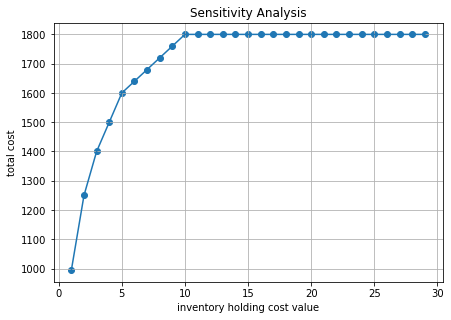

In [11]:
###b)
import matplotlib.pyplot as plt
x=output["inventory holding cost"]
y=output["total cost"]
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.9,0.9])
ax.scatter(x,y)
ax.plot(x,y)
ax.grid(True)
plt.title("Sensitivity Analysis")
plt.xlabel("inventory holding cost value")
plt.ylabel("total cost") 
plt.savefig("Sensitivity Analysis outcome.pdf")

In [12]:
##3 extension
model = Model(name="Capacitated lot sizing model-extension")
data=pd.ExcelFile('lotsizing.xlsx')
#import data
products=[1,2]
time=[1,2,3,4,5,6,7,8,9,10]
demand=pd.DataFrame(data=data.parse('demand',index_col=0,header=0,usecols='A:K',nrows=3))
costs=pd.DataFrame(data=data.parse('costs',index_col=0,header=0,usecols='A:C',nrows=3))
M=1000
c=150
pc=pd.DataFrame(data=data.parse('production_coefficients',index_col=0,header=0,usecols='A:B',nrows=3))
I0=pd.DataFrame(data=data.parse('starting_inventories',index_col=0,header=0,usecols='A:B',nrows=3))
#define the decision variable
#production quantity
X = model.continuous_var_matrix(time, products, name = "prod") 
#inventory level
Y = model.continuous_var_matrix(time, products, name = "inv") 
O = model.binary_var_matrix(time,products)
#define all contraint
#inventory balance
model.add_constraints(Y[t-1,p]+X[t,p]-demand.loc[p,t]==Y[t,p]for t in range (2,11) for p in products)
model.add_constraints(I0.loc[p,"initial inventory"]+X[1,p]-demand.loc[p,1]==Y[1,p]for p in products)
model.add_constraints(X[t,p]<=M*O[t,p]for t in time for p in products)
model.add_constraints(model.sum(pc.loc[p,"production coefficient"]*X[t,p]for p in products)<=c for t in time)
#new limitation
model.add_constraints(O[t,1]+O[t+1,1]<=1for t in range(1,10))
##if there are production in period t ,O[t,1]will be one,otherwise, will be zero
##Through the limitation for two consecutive period 
##smaller than 1,we can make sure that for all period for product 1,there won't have contineous production
#objective function
ZE=model.sum(costs.loc[p,"inventory costs per unit and period"]*Y[t,p]+costs.loc[p,"setup costs per setup"]*O[t,p]for t in time for p in products)

model.minimize(ZE)
model.solve()

header_3=["period","production P1","production P2","total production quantity for product 1 and 2","p1 inventory level","p2 inventory level","total inventory level","set up cost for p1","set up cost for p2","set up cost","inventory cost for p1","inventory cost for p2","inventory cost","total relevant costs","setup cost/total relevant cost"]
df_3=pd.DataFrame(columns=header_3)
for t in time:
    i=len(df_3)
    df_3.loc[i,"period"]=t
    df_3.loc[i,"production P1"] = X[t,1].solution_value
    df_3.loc[i,"production P2"] = X[t,2].solution_value
    df_3.loc[i,"p1 inventory level"] = Y[t,1].solution_value
    df_3.loc[i,"p2 inventory level"] = Y[t,2].solution_value
    df_3.loc[i,"total inventory level"] = Y[t,2].solution_value+Y[t,1].solution_value
    df_3.loc[i,"total production quantity for product 1 and 2"] = X[t,1].solution_value+X[t,2].solution_value
    df_3.loc[i,"set up cost for p1"] = costs.loc[1,"setup costs per setup"]*O[t,1].solution_value
    df_3.loc[i,"set up cost for p2"] = costs.loc[2,"setup costs per setup"]*O[t,2].solution_value
    df_3.loc[i,"set up cost"] = costs.loc[1,"setup costs per setup"]*O[t,1].solution_value+costs.loc[2,"setup costs per setup"]*O[t,2].solution_value
    df_3.loc[i,"inventory cost for p1"]=costs.loc[1,"inventory costs per unit and period"]*Y[t,1].solution_value
    df_3.loc[i,"inventory cost for p2"]=costs.loc[2,"inventory costs per unit and period"]*Y[t,2].solution_value
    df_3.loc[i,"inventory cost"]=costs.loc[1,"inventory costs per unit and period"]*Y[t,1].solution_value+costs.loc[2,"inventory costs per unit and period"]*Y[t,2].solution_value
    df_3.loc[i,"total relevant costs"]= costs.loc[1,"setup costs per setup"]*O[t,1].solution_value+costs.loc[2,"setup costs per setup"]*O[t,2].solution_value+costs.loc[1,"inventory costs per unit and period"]*Y[t,1].solution_value+costs.loc[2,"inventory costs per unit and period"]*Y[t,2].solution_value
    a_1=max(model.sum(costs.loc[1,"setup costs per setup"]*O[t,1].solution_value+costs.loc[2,"setup costs per setup"]*O[t,2].solution_value+costs.loc[1,"inventory costs per unit and period"]*Y[t,1].solution_value +costs.loc[2,"inventory costs per unit and period"]*Y[t,2].solution_value),0)
    b_1=max(model.sum(costs.loc[1,"setup costs per setup"]*O[t,1].solution_value+costs.loc[2,"setup costs per setup"]*O[t,2].solution_value),0)
    if a_1 == 0:
        df_3.loc[i,"setup cost/total relevant cost"]=0
    else:
        df_3.loc[i,"setup cost/total relevant cost"]=b_1/a_1
print(df_3)

print("df_3 is over")

header_10=["sum of production p1","sum of production p2","total production","sum of inventory p1","sum of inventory p2","total inventory","sum of setup cost","sum of inventory holding cost","sum of total relevant costs","sum of proportional"]
df_10=pd.DataFrame(columns=header_10)
df_10.loc[0,"sum of production p1"]=model.sum(X[t,1].solution_value for t in time)
df_10.loc[0,"sum of production p2"]=model.sum(X[t,2].solution_value for t in time)
df_10.loc[0,"total production"]=model.sum(X[t,p].solution_value for t in time for p in products)
df_10.loc[0,"sum of inventory p1"]=model.sum(Y[t,1].solution_value for t in time)
df_10.loc[0,"sum of inventory p2"]=model.sum(Y[t,2].solution_value for t in time)
df_10.loc[0,"total inventory"]=model.sum(Y[t,p].solution_value for t in time for p in products)
df_10.loc[0,"sum of setup cost"]=model.sum(costs.loc[p,"setup costs per setup"]*O[t,p].solution_value for p in products for t in time)
df_10.loc[0,"sum of inventory holding cost"]=model.sum(costs.loc[p,"inventory costs per unit and period"]*Y[t,p].solution_value for p in products for t in time)
df_10.loc[0,"sum of total relevant costs"]=model.sum(costs.loc[p,"setup costs per setup"]*O[t,p].solution_value for p in products for t in time)+model.sum(costs.loc[p,"inventory costs per unit and period"]*Y[t,p].solution_value for p in products for t in time)
df_10.loc[0,"sum of proportional"]=model.sum(df_3.loc[t-1,"setup cost/total relevant cost"] for t in time)

print(df_10)
print("The objective value is ", model.objective_value) # costs are expressed in hundreds of euro!


  period production P1 production P2  \
0      1          70.0          30.0   
1      2             0             0   
2      3          60.0             0   
3      4             0          85.0   
4      5          80.0             0   
5      6             0             0   
6      7             0             0   
7      8          90.0          35.0   
8      9             0             0   
9     10             0             0   

  total production quantity for product 1 and 2 p1 inventory level  \
0                                         100.0               50.0   
1                                             0                  0   
2                                          60.0               50.0   
3                                          85.0                  0   
4                                          80.0               30.0   
5                                             0               20.0   
6                                             0                  0   

In [13]:
# write the results 
with pd.ExcelWriter('extension_result.xlsx') as writer:  
    df_3.to_excel(writer, sheet_name='result #1')
    df_10.to_excel(writer, sheet_name='result #2')

df_3

,period,production P1,production P2,total production quantity for product 1 and 2,p1 inventory level,p2 inventory level,total inventory level,set up cost for p1,set up cost for p2,set up cost,inventory cost for p1,inventory cost for p2,inventory cost,total relevant costs,setup cost/total relevant cost
0,1,70.0,30.0,100.0,50.0,20.0,70.0,100.0,100.0,200.0,50.0,20.0,70.0,270.0,0.740741
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,60.0,0,60.0,50.0,0,50.0,100.0,0,100.0,50.0,0,50.0,150.0,0.666667
3,4,0,85.0,85.0,0,35.0,35.0,0,100.0,100.0,0,35.0,35.0,135.0,0.740741
4,5,80.0,0,80.0,30.0,10.0,40.0,100.0,0,100.0,30.0,10.0,40.0,140.0,0.714286
5,6,0,0,0,20.0,0,20.0,0,0,0,20.0,0,20.0,20.0,0.0
6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,8,90.0,35.0,125.0,50.0,20.0,70.0,100.0,100.0,200.0,50.0,20.0,70.0,270.0,0.740741
8,9,0,0,0,30.0,10.0,40.0,0,0,0,30.0,10.0,40.0,40.0,0.0
9,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0
